In [1]:
import os; import sys ; import matplotlib as mpl ; import matplotlib.pyplot as plt ; import numpy as np
import pathlib; from pathlib import Path; import pandas as pd; import flopy; from flopy.utils.util_array import read1d

In [2]:
example_name = "MT3D_tutorial_09"
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf2005'
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64'
datadir = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3dms'
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\98_Plus\02_MT3D


In [12]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\98_Plus\\02_MT3D')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'ex-RES'    ; workspace = os.path.join('.', directory_name)
if os.path.isdir(workspace) is False:
    os.mkdir(workspace)                         
output_folder = Path('ex-RES\\p09') ; output_folder.mkdir(exist_ok=True)

In [4]:
def p09(dirname, mixelm, nadvfd):
    model_ws = os.path.join(workspace, dirname)
    nlay = 1 ;  nrow = 18 ; ncol = 14 ; delr = 100 ; delc = 100  ; delv = 10 ; prsity = 0.3   ; al = 20.0 ; trpt = 0.2 ; 
    perlen_mf = 1.0 ; perlen_mt = [365.0 * 86400, 365.0 * 86400] ; laytyp = 0 ; k1 = 1.474e-4 ; k2 = 1.474e-7 ; 
    hk = k1 * np.ones((nlay, nrow, ncol), dtype=float)           ; hk[:, 5:8, 1:8] = k2  
    modelname_mf = dirname + "_mf"
    mf = flopy.modflow.Modflow(modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis(mf,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=0.0,botm=[0 - delv],perlen=perlen_mf)
    ibound = np.ones((nlay, nrow, ncol), dtype=int)    ; ibound[0, 0, :] = -1   ; ibound[0, -1, :] = -1
    strt = np.zeros((nlay, nrow, ncol), dtype=float)   ; strt[0, 0, :] = 250.0                         ; xc = mf.modelgrid.xcellcenters
    for j in range(ncol):
        strt[0, -1, j] = 20.0 + (xc[0, j] - xc[0, 0]) * 2.5 / 100
        
    bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf(mf, hk=hk, laytyp=laytyp)                  ; welspd = [[0, 3, 6, 0.001], [0, 10, 6, -0.0189]]
    wel = flopy.modflow.ModflowWel(mf, stress_period_data=welspd)
    pcg = flopy.modflow.ModflowPcg(mf)
    lmt = flopy.modflow.ModflowLmt(mf)          ; mf.write_input()     ; mf.run_model(silent=True)

    modelname_mt = dirname + "_mt"
    mt = flopy.mt3d.Mt3dms(modelname=modelname_mt,model_ws=model_ws,exe_name=exe_name_mt,modflowmodel=mf)
    btn = flopy.mt3d.Mt3dBtn(mt,icbund=1,prsity=prsity,sconc=0,nper=2,perlen=perlen_mt  ,obs = [[0, 10, 6]] )                       # OBS
#   btn = flopy.mt3d.Mt3dBtn(mt,icbund=1,prsity=prsity,sconc=0,nper=2,perlen=perlen_mt  ,  timprs=[8 * 365, 12 * 365, 20 * 365])    # other
    percel = 1.0 ; itrack = 2 ; dceps = 1.0e-5 ; nplane = 0 ; npl = 0 ; nph = 16 ; npmin = 0 ; npmax = 32 ; dchmoc = 1.0e-3 ; 
    nlsink = nplane ; npsink = nph ; 
    adv = flopy.mt3d.Mt3dAdv(mt,mixelm=mixelm,dceps=dceps,nplane=nplane,npl=npl,nph=nph,npmin=npmin,npmax=npmax,
                             nlsink=nlsink,npsink=npsink,percel=percel,itrack=itrack                            , nadvfd = nadvfd)               
#   adv = flopy.mt3d.Mt3dAdv(mt,mixelm=mixelm,dceps=dceps,nplane=nplane,npl=npl,nph=nph,npmin=npmin,npmax=npmax,
#                            nlsink=nlsink,npsink=npsink,percel=percel,itrack=itrack                            , wd = wd)                            
    dsp = flopy.mt3d.Mt3dDsp(mt, al=al, trpt=trpt)
    spd = {0: [[0, 3, 6, 57.87, 2], [0, 10, 6, 0.0, 2]]      , 1: [[0, 3, 6, 0.0, 2], [0, 10, 6, 0.0, 2]],}
    ssm = flopy.mt3d.Mt3dSsm(mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg(mt)                             ; mt.write_input()
    fname = os.path.join(model_ws, "MT3D001.UCN")
    if os.path.isfile(fname):
        os.remove(fname)
    mt.run_model(silent=True)  # ___________________________ ; run 
    
    fname = os.path.join(model_ws, "MT3D001.UCN") ; ucnobj = flopy.utils.UcnFile(fname) ; times = ucnobj.get_times() ; conc = ucnobj.get_alldata()
    fname = os.path.join(model_ws, "MT3D001.OBS")
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None
    fname = os.path.join(model_ws, "MT3D001.MAS") ; mvt = mt.load_mas(fname)
    return mf, mt, conc, times, cvt, mvt

Text(0.5, 1.0, 'ULTIMATE')

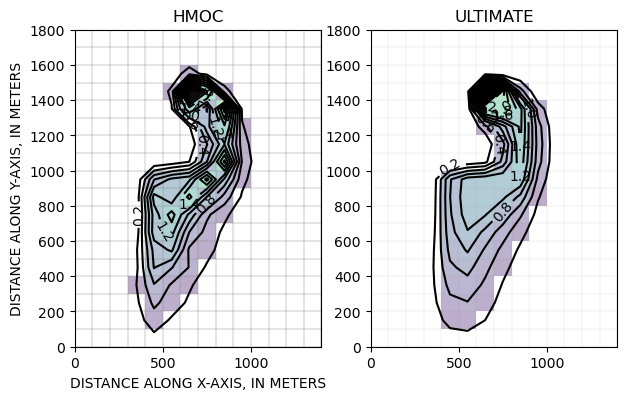

In [5]:
fig = plt.figure(figsize=(7, 5))                ; levels = np.arange(0.2, 10, 0.2)

ax = fig.add_subplot(1, 2, 1, aspect="equal")   ; mf, mt, conc, times, cvt, mvt = p09("p09", 3, 1)
cvt["time"] / 365.0 / 86400.0                   ; y = cvt["(1, 11, 7)"]    ; conc = conc[:, 0, :, :]  ; cflood = np.ma.masked_less_equal(conc, 0.2)
pmv = flopy.plot.PlotMapView(ax=ax, model=mf)   ; pmv.plot_grid(color=".5", alpha=0.2)
cs = pmv.plot_array(cflood[0], alpha=0.2, vmin=0, vmax=3)        ; cs = pmv.contour_array(conc[0], colors="k", levels=levels)
plt.clabel(cs) ; plt.xlabel("X(m)")  ; plt.ylabel("Y(m)") ; plt.title("HMOC")

ax = fig.add_subplot(1, 2, 2, aspect="equal")   ; mf, mt, conc, times, cvt, mvt = p09("p09", -1, 1)
cvt["time"] / 365.0 / 86400.0                   ; y = cvt["(1, 11, 7)"]    ; conc = conc[:, 0, :, :]  ; cflood = np.ma.masked_less_equal(conc, 0.2)
pmv = flopy.plot.PlotMapView(ax=ax, model=mf)   ; pmv.plot_grid(color=".5", alpha=0.05)
cs = pmv.plot_array(cflood[0], alpha=0.2, vmin=0, vmax=3)         ; cs = pmv.contour_array(conc[0], colors="k", levels=levels)
plt.clabel(cs) ; plt.xlabel("") ; plt.ylabel("") ; plt.title("ULTIMATE")

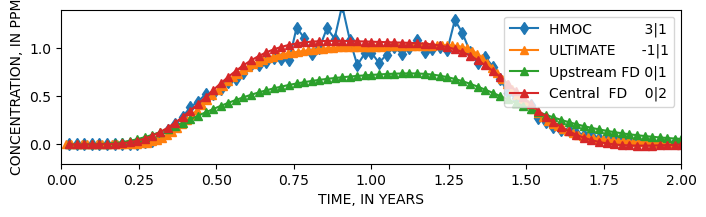

In [24]:
fig = plt.figure(figsize=(8, 2))           ; ax = fig.add_subplot(1, 1, 1)  # ____ 3, -1, 0, 0  # ____ 1,1,1,2
mf,mt,conc,times,cvt,mvt= p09("p09",  3, 1) ; x = cvt["time"]/365/86400 ; y = cvt["(1, 11, 7)"] ; plt.plot(x,y,label="HMOC            3|1", marker="d")
mf,mt,conc,times,cvt,mvt= p09("p09", -1, 1) ; x = cvt["time"]/365/86400 ; y = cvt["(1, 11, 7)"] ; plt.plot(x,y,label="ULTIMATE      -1|1" , marker="^")
mf,mt,conc,times,cvt,mvt= p09("p09",  0, 1) ; x = cvt["time"]/365/86400 ; y = cvt["(1, 11, 7)"] ; plt.plot(x,y,label="Upstream FD 0|1" , marker="^")
mf,mt,conc,times,cvt,mvt= p09("p09",  0, 2) ; x = cvt["time"]/365/86400 ; y = cvt["(1, 11, 7)"] ; plt.plot(x,y,label="Central  FD    0|2",marker="^")
plt.xlim(0, 2) ;  plt.ylim(-0.2, 1.4) ; plt.xlabel("TIME, IN YEARS") ;  plt.ylabel("CONCENTRATION, IN PPM") ; plt.legend()

In [7]:
type(times)

list

In [8]:
print('conc = ', conc.shape), print('cvt = ', cvt.shape)

conc =  (2, 1, 18, 14)
cvt =  (82,)


(None, None)

In [9]:
type(cvt)

numpy.recarray

In [10]:
save = pd.DataFrame(cvt)   

In [13]:
save.to_csv (output_folder / "cvt.csv") 